### Debiasing CPM with CEBaB
Our Causal Proxy Model (CPM) has localized information about different concepts. The overall debiasing effort in CPM is letting the model to predict the output as if the concept that gets to be debiased is not presented in the text (i.e., the concept label is ``unknown``).

In this document, we show that CPM can be integrated as a method to produce debiased model with respect to targeted concept. This document is just one example of how we can use CPM to produce debiased outputs. In the paper, we also discuss how the iCACE score relates to this debiased results.

In this notebook, we will evaluate the following models:
- CPM: `BERT-base-uncased`

and we will evaluate with the following conditions:
- 5-class

#### Imports and Libs

In [1]:
from libs import *
"""
For evaluate, we use a single random seed, as
the models are trained with 5 different seeds
already.
"""
_ = random.seed(123)
_ = np.random.seed(123)
_ = torch.manual_seed(123)

In [2]:
"""
This is another interface for defining CPM.
We later found that there is essentially no
different between this static way versus sampling
on-the-fly for CPM model evaluation. We use
this interface for debiasing as it is easier to
run experiments with.
"""
class StaticCausalProxyModelForBERT(Explainer):
    def __init__(
        self, 
        blackbox_model_path,
        cpm_model_path, 
        device, batch_size, 
        intervention_h_dim=1,
        min_iit_pair_examples=1,
        match_non_int_type=False,
        cache_dir="../../huggingface_cache"
    ):
        self.batch_size = batch_size
        self.device = device
        self.min_iit_pair_examples = min_iit_pair_examples
        self.match_non_int_type = match_non_int_type
        self.intervention_h_dim = intervention_h_dim
        # blackbox model loading.
        self.blackbox_model = BertForNonlinearSequenceClassification.from_pretrained(
            blackbox_model_path,
            cache_dir=cache_dir
        )
        self.blackbox_model.to(device)
        
        # causal proxy model loading.
        cpm_config = AutoConfig.from_pretrained(
            cpm_model_path,
            cache_dir=cache_dir,
            use_auth_token=True if "CEBaB/" in cpm_model_path else False,
        )
        try:
            cpm_config.intervention_h_dim = cpm_config.intervention_h_dim
        except:
            cpm_config.intervention_h_dim = intervention_h_dim
        print(f"intervention_h_dim={cpm_config.intervention_h_dim}")
        cpm_model = IITBERTForSequenceClassification.from_pretrained(
            cpm_model_path,
            config=cpm_config,
            cache_dir=cache_dir,
        )
        cpm_model.to(device)
        self.cpm_model = InterventionableIITTransformerForSequenceClassification(
            model=cpm_model
        )
        
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        
        self.clean()
        
    def clean(self):
        self.hidden_repr_static_pool = {}
        for concept in ["ambiance", "food", "noise", "service"]:
            for concept_label in ["Positive", "Negative", "unknown"]:
                self.hidden_repr_static_pool[(concept, concept_label)] = []
        
    def fit(self, 
            dataset, classifier_predictions, 
            classifier, dev_dataset=None,
            reduce=False, control=False,
           ):
        """
        For static CPM model, we need to extract the hidden representations for
        concepts before estimating iCACE scores.
        """
        self.blackbox_model.eval()
        self.cpm_model.model.eval()

        x, y, ambiance_label, food_label, noise_label, service_labal = self.preprocess(dataset)

        # get the predictions batch per batch
        cls_hidden_states = []
        for i in range(ceil(len(dataset) / self.batch_size)):
            x_batch = {k: v[i * self.batch_size:(i + 1) * self.batch_size].to(self.device) for k, v in x.items()}
            if control:
                cls_hidden_state = self.blackbox_model(
                    **x_batch,
                    output_hidden_states=True,
                ).hidden_states[-1][:,0,:].cpu().detach()
            else:
                cls_hidden_state = self.cpm_model.model(
                    **x_batch,
                    output_hidden_states=True,
                ).hidden_states[-1][:,0,:].cpu().detach()
            cls_hidden_states.append(cls_hidden_state)

        cls_hidden_states = torch.concat(cls_hidden_states)
        
        for i in range(0, len(ambiance_label)): 
            if ("ambiance", ambiance_label.iloc[i]) in self.hidden_repr_static_pool:
                start_idx = 0*self.intervention_h_dim
                end_idx = 1*self.intervention_h_dim
                self.hidden_repr_static_pool[("ambiance", ambiance_label.iloc[i])].append(
                    cls_hidden_states[i][start_idx:end_idx]
                )
            
            if ("food", food_label.iloc[i]) in self.hidden_repr_static_pool:
                start_idx = 1*self.intervention_h_dim
                end_idx = 2*self.intervention_h_dim
                self.hidden_repr_static_pool[("food", food_label.iloc[i])].append(
                    cls_hidden_states[i][start_idx:end_idx]
                )
                
            if ("noise", noise_label.iloc[i]) in self.hidden_repr_static_pool:
                start_idx = 2*self.intervention_h_dim
                end_idx = 3*self.intervention_h_dim
                self.hidden_repr_static_pool[("noise", noise_label.iloc[i])].append(
                    cls_hidden_states[i][start_idx:end_idx]
                )
                
            if ("service", service_labal.iloc[i]) in self.hidden_repr_static_pool:
                start_idx = 3*self.intervention_h_dim
                end_idx = 4*self.intervention_h_dim
                self.hidden_repr_static_pool[("service", service_labal.iloc[i])].append(
                    cls_hidden_states[i][start_idx:end_idx]
                )

        if reduce:
            for k, v in self.hidden_repr_static_pool.items():
                self.hidden_repr_static_pool[k] = torch.stack(v, dim=0).mean(dim=0)
        else:
            for k, v in self.hidden_repr_static_pool.items():
                self.hidden_repr_static_pool[k] = torch.stack(v, dim=0)
            
    def preprocess(self, df):
        x = self.tokenizer(df['description'].to_list(), padding=True, truncation=True, return_tensors='pt')
        y = df['review_majority'].astype(int)

        all_type = {
            "ambiance", "food", "noise", "service"
        }
        return x, y, \
            df['ambiance_aspect_majority'], \
            df['food_aspect_majority'], \
            df['noise_aspect_majority'], \
            df['service_aspect_majority']
    
    def preprocess_icace(self, pairs_dataset):
        
        # configs
        iit_pairs_dataset = []
        iit_id = 0
        for index, row in pairs_dataset.iterrows():
            query_description_base = row['description_base']
            query_int_type = row['intervention_type']
            query_int_aspect_base = row["intervention_aspect_base"]
            query_int_aspect_assignment = row['intervention_aspect_counterfactual']
            query_original_id = row["original_id_base"]
            iit_pairs_dataset += [[
                iit_id,
                query_int_type,
                query_description_base, 
                query_int_aspect_base,
                query_int_aspect_assignment
            ]]
            iit_id += 1
        iit_pairs_dataset = pd.DataFrame(
            columns=[
                'iit_id',
                'intervention_type', 
                'description_base', 
                'intervention_aspect_base',
                'intervention_aspect_counterfactual'], 
            data=iit_pairs_dataset
        )
        
        base_x = self.tokenizer(
            iit_pairs_dataset['description_base'].to_list(), 
            padding=True, truncation=True, return_tensors='pt'
        )

        intervention_corr = []
        source_x = []
        for i in range(len(iit_pairs_dataset["intervention_type"])):
            _type = iit_pairs_dataset["intervention_type"].iloc[i]
            _base_label = iit_pairs_dataset["intervention_aspect_base"].iloc[i]
            _label = iit_pairs_dataset["intervention_aspect_counterfactual"].iloc[i]
            if _type == "ambiance":
                intervention_corr += [0]
            if _type == "food":
                intervention_corr += [1]
            if _type == "noise":
                intervention_corr += [2]
            if _type == "service":
                intervention_corr += [3]
                
            """
            UNCOMMENT TO TRY:
            
            Just to try out if we actually care about the difference.
            This will need some modifications on the modeling files as well
            to consume this as a delta, not activation replacement.
            """
            # source_x += [
            #     self.hidden_repr_static_pool[(_type, _label)] - \
            #         self.hidden_repr_static_pool[(_type, _base_label)]
            # ]
            
            hidden_repr_static_pool = self.hidden_repr_static_pool[(_type, _label)]
            hidden_repr_static_sampled = hidden_repr_static_pool[random.randrange(hidden_repr_static_pool.shape[0])]
            source_x += [hidden_repr_static_sampled]
            
        source_x = torch.stack(source_x, dim=0)
        intervention_corr = torch.tensor(intervention_corr).long()
        return base_x, source_x, intervention_corr, iit_pairs_dataset
    
    def estimate_icace(self, pairs):
        
        CPM_iTEs = []
        self.blackbox_model.eval()
        self.cpm_model.model.eval()
        base_x, source_x, intervention_corr, iit_pairs_dataset = self.preprocess_icace(
            pairs,
        )
        with torch.no_grad():
            for i in tqdm(range(ceil(len(iit_pairs_dataset)/self.batch_size))):
                base_x_batch = {k:v[i*self.batch_size:(i+1)*self.batch_size].to(self.device) for k,v in base_x.items()} 
                source_x_batch = source_x[i*self.batch_size:(i+1)*self.batch_size].to(self.device)
                intervention_corr_batch = intervention_corr[i*self.batch_size:(i+1)*self.batch_size].to(self.device)
                
                base_outputs = torch.nn.functional.softmax(
                    self.blackbox_model(**base_x_batch).logits.cpu(), dim=-1
                ).detach()
                _, _, counterfactual_outputs = self.cpm_model.forward_with_hook(
                    base=(base_x_batch['input_ids'], base_x_batch['attention_mask']),
                    source_hidden_reprs=source_x_batch,
                    base_intervention_corr=intervention_corr_batch,
                    source_intervention_corr=intervention_corr_batch,
                )
                counterfactual_outputs = torch.nn.functional.softmax(
                    counterfactual_outputs["logits"][0].cpu(), dim=-1
                ).detach()
                CPM_iTE = counterfactual_outputs-base_outputs
                CPM_iTEs.append(CPM_iTE)
        CPM_iTEs = torch.concat(CPM_iTEs)
        CPM_iTEs = np.round(CPM_iTEs.numpy(), decimals=4)

        # only for iit explainer!
        iit_pairs_dataset["EiCaCE"] = list(CPM_iTEs)
        CPM_iTEs = list(iit_pairs_dataset.groupby(["iit_id"])["EiCaCE"].mean())
        
        return CPM_iTEs
    

In [3]:
seed=42
class_num=5
beta=1.0
gemma=3.0
h_dim=192
dataset_type = f'{class_num}-way'
correction_epsilon=None
cls_dropout=0.1
enc_dropout=0.1
control=False
model_arch="bert-base-uncased"
if model_arch == "bert-base-uncased":
    model_path = "BERT-control-results" if control else "BERT-results"
elif model_arch == "roberta-base":
    model_path = "RoBERTa-control-results" if control else "RoBERTa-results"
elif model_arch == "gpt2":
    model_path = "gpt2-control-results" if control else "gpt2-results"
elif model_arch == "lstm":
    model_path = "lstm-control-results" if control else "lstm-results"
    
device='cuda:9'
batch_size=32
    
blackbox_model_path = f'CEBaB/{model_arch}.CEBaB.sa.{class_num}-class.exclusive.seed_{seed}'
if control:
    cpm_model_path = blackbox_model_path
else:
    cpm_model_path = f'../proxy_training_results/{model_path}/'\
                       f'cebab.train.train.alpha.1.0'\
                       f'.beta.{beta}.gemma.{gemma}.dim.{h_dim}.hightype.'\
                       f'{model_arch}.Proxy.'\
                       f'CEBaB.sa.{class_num}-class.exclusive.'\
                       f'mode.align.cls.dropout.{cls_dropout}.enc.dropout.{enc_dropout}.seed_{seed}'

# load data from HF
cebab = datasets.load_dataset(
    'CEBaB/CEBaB', use_auth_token=True,
    cache_dir="../../huggingface_cache/"
)
train, dev, test = preprocess_hf_dataset(
    cebab, one_example_per_world=True, 
    verbose=1, dataset_type=dataset_type
)

train_dataset = train.copy()
dev_dataset = test.copy()

Using custom data configuration CEBaB--CEBaB-0e2f7ed67c9d7e55


Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to ../../huggingface_cache/CEBaB___parquet/CEBaB--CEBaB-0e2f7ed67c9d7e55/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8. Subsequent calls will reuse this data.


  0%|          | 0/4 [00:00<?, ?it/s]

Dropping no majority reviews: 16.6382% of train dataset.


In [4]:
# loading for control
cpm_control_explainer = StaticCausalProxyModelForBERT(
    blackbox_model_path,
    blackbox_model_path, 
    device=device, 
    batch_size=batch_size,
    intervention_h_dim=h_dim,
)
cpm_control_explainer.clean()
cpm_control_explainer.fit(
    train_dataset, 
    None, None, None,
    reduce=False, control=True,
)

# loading for cpm (same way but different usages)
cpm_explainer = StaticCausalProxyModelForBERT(
    blackbox_model_path,
    cpm_model_path, 
    device=device, 
    batch_size=batch_size,
    intervention_h_dim=h_dim,
)
cpm_explainer.clean()
cpm_explainer.fit(
    train_dataset, 
    None, None, None,
    reduce=False, control=False,
)

intervention_h_dim=192


Some weights of IITBERTForSequenceClassification were not initialized from the model checkpoint at CEBaB/bert-base-uncased.CEBaB.sa.5-class.exclusive.seed_42 and are newly initialized: ['multitask_classifier.out_proj.weight', 'multitask_classifier.out_proj.bias', 'multitask_classifier.dense.bias', 'multitask_classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


intervention_h_dim=192


In [19]:
decorrelate_concept = "food" # TODO: integrate this, make it as a function!

correlate_results = []
decorrelate_results = []
control_results = []
for index, row in dev_dataset.iterrows():
    ambiance = row['ambiance_aspect_majority']
    food = row['food_aspect_majority']
    noise = row['noise_aspect_majority']
    service = row['service_aspect_majority']
    description = row['description']

    cpm_control_explainer.blackbox_model.eval()
    cpm_control_explainer.cpm_model.model.eval()
    cpm_explainer.blackbox_model.eval()
    cpm_explainer.cpm_model.model.eval()
    
    # Original ratings.
    x = cpm_explainer.tokenizer([description], padding=True, truncation=True, return_tensors='pt')
    x_batch = {k: v.to(cpm_explainer.device) for k, v in x.items()}
    outputs = cpm_explainer.cpm_model.model(
        **x_batch,
        output_hidden_states=True,
    )
    output_logit = torch.nn.functional.softmax(
        outputs.logits[0].cpu(), dim=-1
    ).detach()[0]
    vp_class_prob = output_logit[-1].tolist()
    correlate_results += [(ambiance, food, noise, service, vp_class_prob)]
    
    if decorrelate_concept == "ambiance":
        intervention_corr = 0
    if decorrelate_concept == "food":
        intervention_corr = 1
    if decorrelate_concept == "noise":
        intervention_corr = 2
    if decorrelate_concept == "service":
        intervention_corr = 3
    
    # Decorrelate ratings.
    cls_hidden_state = outputs.hidden_states[-1][:,0,:]
    hidden_repr_static_pool = {}
    for k, v in cpm_explainer.hidden_repr_static_pool.items():
        # this is to take the mean, can we do better?
        idx = random.randrange(v.shape[0])
        vv = v[idx].to(cpm_explainer.device)
        hidden_repr_static_pool[k] = vv
    start_idx = intervention_corr*cpm_explainer.intervention_h_dim
    end_idx = (intervention_corr+1)*cpm_explainer.intervention_h_dim
    cls_hidden_state[:, start_idx:end_idx] = hidden_repr_static_pool[(decorrelate_concept, "unknown")]
    intervened_outputs, _, _ = cpm_explainer.cpm_model.forward_with_cls_hidden_reprs(
        cls_hidden_reprs=cls_hidden_state.unsqueeze(dim=1)
    )
    intervened_outputs_logits = torch.nn.functional.softmax(
        intervened_outputs.logits[0].cpu(), dim=-1
    ).detach()[0]
    intervened_vp_class_prob = intervened_outputs_logits[-1].tolist()
    decorrelate_results += [(ambiance, food, noise, service, intervened_vp_class_prob)]
    
    # Control ratings. We need a better baseline!
    control_outputs = cpm_control_explainer.cpm_model.model(
        **x_batch,
        output_hidden_states=True,
    )
    control_cls_hidden_state = control_outputs.hidden_states[-1][:,0,:]
    control_hidden_repr_static_pool = {}
    for k, v in cpm_control_explainer.hidden_repr_static_pool.items():
        # this is to take the mean, can we do better?
        idx = random.randrange(v.shape[0])
        vv = v[idx].to(cpm_control_explainer.device)
        control_hidden_repr_static_pool[k] = vv
    start_idx = intervention_corr*cpm_control_explainer.intervention_h_dim
    end_idx = (intervention_corr+1)*cpm_control_explainer.intervention_h_dim
    control_cls_hidden_state[:, start_idx:end_idx] = control_hidden_repr_static_pool[(decorrelate_concept, "unknown")]
    control_intervened_outputs, _, _ = cpm_control_explainer.cpm_model.forward_with_cls_hidden_reprs(
        cls_hidden_reprs=control_cls_hidden_state.unsqueeze(dim=1)
    )
    control_intervened_outputs_logits = torch.nn.functional.softmax(
        control_intervened_outputs.logits[0].cpu(), dim=-1
    ).detach()[0]
    control_intervened_vp_class_prob = control_intervened_outputs_logits[-1].tolist()
    control_results += [(ambiance, food, noise, service, control_intervened_vp_class_prob)]

In [60]:
def group_logits(
    correlate_results,
    concept_idx,
):
    group_results = {
        "Negative" : [],
        "unknown" : [],
        "Positive" : [],
    }
    for i in range(len(correlate_results)):
        if correlate_results[i][concept_idx] != "":
            logit = correlate_results[i][-1]
            group_results[correlate_results[i][concept_idx]].append(logit)
    return group_results

def subplot_func(ax, index, results, with_labels=False, with_title=False):
    group_result = group_logits(results, index)
    names = ["ambiance", "food", "noise", "service"]
    ax.boxplot(
        np.asarray([
            group_result["Negative"],
            group_result["unknown"],
            group_result["Positive"],
        ], dtype=object), 
        labels=["neg", "unk", "pos"]
    )
    line_x = []
    linx_y = []
    for l in group_result["Negative"]:
        line_x.append(1)
        linx_y.append(l)
    for l in group_result["unknown"]:
        line_x.append(2)
        linx_y.append(l)
    for l in group_result["Positive"]:
        line_x.append(3)
        linx_y.append(l)
    corr, _ = pearsonr(line_x, linx_y)
    corr = round(corr, 2)
    ax.plot(
        np.unique(line_x), np.poly1d(
            np.polyfit(line_x, linx_y, 1)
        )(np.unique(line_x)),
        linestyle='dashdot',
        color='crimson',
        alpha=0.8,
        linewidth=1,
        label=f"corr={corr}"
    )
    ax.legend(
        loc="upper right",
        ncol=1, fancybox=True, shadow=True, fontsize=12,
        facecolor="white",
    )
    if with_title:
        ax.set_title(names[index], fontsize=20)
    if not with_labels:
        ax.get_xaxis().set_ticks([])
    else:
        ax.xaxis.set_tick_params(labelsize=20)
    
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.xaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    ax.yaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)

    ax.set_facecolor("white")

    return ax

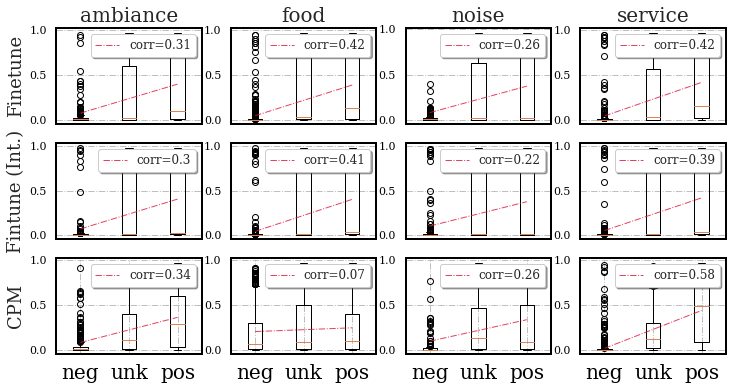

In [62]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    fig, axs = plt.subplots(3, 4, figsize=(12, 6))
    # Blackbox model
    for i in range(0, 4):
        subplot_func(axs[0,i], i, correlate_results, with_title=True)
        axs[0,0].set_ylabel("Finetune", fontsize=18)
        
    # Control
    for i in range(0, 4):
        subplot_func(axs[1,i], i, control_results)
        axs[1,0].set_ylabel("Fintune (Int.)", fontsize=18)
        
    # CPM
    for i in range(0, 4):
        subplot_func(axs[2,i], i, decorrelate_results, with_labels=True)
        axs[2,0].set_ylabel("CPM", fontsize=18)
    plt.savefig("./figures/debiasing.png",dpi=200, bbox_inches='tight')
        